In [1]:
%pip install pandarallel
%pip install nltk
%pip install scikit-learn
%pip install gensim

  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
     ------------------------------------ 115.3/115.3 kB 668.9 kB/s eta 0:00:00
Using legacy 'setup.py install' for pandarallel, since package 'wheel' is not installed.
  Running setup.py install for pandarallel: started
  Running setup.py install for pandarallel: finished with status 'done'
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.2.2 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


     ---------------------------------------- 1.5/1.5 MB 3.2 MB/s eta 0:00:00
     -------------------------------------- 269.6/269.6 kB 5.5 MB/s eta 0:00:00
     ---------------------------------------- 78.3/78.3 kB 4.3 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.2.2 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.2.2 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


     ---------------------------------------- 24.0/24.0 MB 3.5 MB/s eta 0:00:00
     ---------------------------------------- 57.0/57.0 kB 1.5 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.2.2 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1]:
import time
import pandas as pd
import nltk
import numpy as np
import gensim
from sklearn.metrics import accuracy_score
from gensim.models.doc2vec import Doc2Vec
from tqdm import tqdm
from pandarallel import pandarallel
from sklearn.model_selection import train_test_split
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

In [8]:
column_names = ["polarity", "id", "date", "query", "username", "text"]
df = pd.read_csv(
    "./training.1600000.processed.noemoticon.csv",
    delimiter=",",
    encoding="latin",
    names=column_names,
)
df = df[["polarity", "text"]]
df["Preprocessed_text"] = ""

In [9]:
print(df.head())
print(len(df["polarity"]))

   polarity                                               text  \
0         0  @switchfoot http://twitpic.com/2y1zl - Awww, t...   
1         0  is upset that he can't update his Facebook by ...   
2         0  @Kenichan I dived many times for the ball. Man...   
3         0    my whole body feels itchy and like its on fire    
4         0  @nationwideclass no, it's not behaving at all....   

  Preprocessed_text  
0                    
1                    
2                    
3                    
4                    
1600000


In [10]:
pandarallel.initialize(progress_bar=True)


def preprocess(text):
    from nltk.tokenize import sent_tokenize
    from string import punctuation
    from nltk.tokenize import word_tokenize
    from nltk.corpus import stopwords
    from nltk.stem import WordNetLemmatizer

    sentences = sent_tokenize(text)
    # Lower case
    sentences = [sentence.lower() for sentence in sentences]
    # Remove punctuation
    sentences = [
        "".join(c for c in sentence if c not in punctuation) for sentence in sentences
    ]
    # Tokenize words
    sentences = [word_tokenize(sentence) for sentence in sentences]
    # Remove stopwords
    stop_words = stopwords.words("english")
    sentences = [
        [word for word in sentence if word not in stop_words] for sentence in sentences
    ]
    # Remove links
    sentences = [
        [word for word in sentence if not word.startswith("http")]
        for sentence in sentences
    ]
    # Lemmatize
    lemmatizer = WordNetLemmatizer()
    sentences = [
        [lemmatizer.lemmatize(word) for word in sentence] for sentence in sentences
    ]
    words = " ".join([" ".join(sentence) for sentence in sentences])
    return words

INFO: Pandarallel will run on 6 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.

https://nalepae.github.io/pandarallel/troubleshooting/


In [11]:
df["Preprocessed_text"] = ""

df["Preprocessed_text"] = df["text"].parallel_apply(preprocess)

# Save the DataFrame to a new CSV file
df.to_csv("preprocess_data.csv", index=False)

In [2]:
df_prep = pd.read_csv("./preprocess_data.csv")
df_prep = df_prep.dropna(subset=["Preprocessed_text"])
print(df_prep.head())

   polarity                                               text  \
0         0  @switchfoot http://twitpic.com/2y1zl - Awww, t...   
1         0  is upset that he can't update his Facebook by ...   
2         0  @Kenichan I dived many times for the ball. Man...   
3         0    my whole body feels itchy and like its on fire    
4         0  @nationwideclass no, it's not behaving at all....   

                                   Preprocessed_text  
0  switchfoot awww thats bummer shoulda got david...  
1  upset cant update facebook texting might cry r...  
2  kenichan dived many time ball managed save 50 ...  
3                    whole body feel itchy like fire  
4          nationwideclass behaving im mad  cant see  


In [3]:
X = df_prep["Preprocessed_text"]
y = df_prep["polarity"]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [34]:
total_epochs = 10

tagged_data = [
    TaggedDocument(words=doc.split(), tags=[str(i)]) for i, doc in enumerate(X_train)
]

model = Doc2Vec(
    min_count=3,
    vector_size=100,
    window=5,
    workers=6,
    seed=42,
    epochs=total_epochs,
    batch_words=10000,
    compute_loss=True,
    hs=0,
    negative=10,
)

In [ ]:
model.build_vocab(tagged_data)

In [17]:
for epoch in range(total_epochs):
    start_time = time.time()
    model.train(tagged_data, total_examples=model.corpus_count, epochs=1)
    end_time = time.time()
    time_elapsed = end_time - start_time
    print(
        f"Epoch {epoch + 1}/{total_epochs} completed. Time elapsed: {time_elapsed:.2f} seconds"
    )

model.save("doc2vec_model.model")

Epoch 1/10 completed. Time elapsed: 101.15 seconds
Epoch 2/10 completed. Time elapsed: 100.94 seconds
Epoch 3/10 completed. Time elapsed: 100.59 seconds
Epoch 4/10 completed. Time elapsed: 100.45 seconds
Epoch 5/10 completed. Time elapsed: 100.70 seconds
Epoch 6/10 completed. Time elapsed: 100.45 seconds
Epoch 7/10 completed. Time elapsed: 100.49 seconds
Epoch 8/10 completed. Time elapsed: 100.61 seconds
Epoch 9/10 completed. Time elapsed: 100.21 seconds
Epoch 10/10 completed. Time elapsed: 100.26 seconds


In [41]:
model = gensim.models.Word2Vec.load("./doc2vec_model.model")

TypeError: __randomstate_ctor() takes from 0 to 1 positional arguments but 2 were given

In [36]:
def s(DATA):
    inferred_vectors = []

    with tqdm(total=len(DATA)) as pbar:
        for text in DATA:
            text = str(text)  # Ensure text is a string
            vector = model.infer_vector(text.split())
            inferred_vectors.append(vector)
            pbar.update(1)  # Update the progress bar

    return inferred_vectors

In [37]:
inferred_vectors = s(X_train)

print("Number of training samples:", len(inferred_vectors))
print("Number of training labels:", len(y_train))

  0%|          | 0/1279715 [00:00<?, ?it/s]


AttributeError: 'Doc2Vec' object has no attribute 'syn1neg'

In [38]:
unique_values, counts = np.unique(y_train, return_counts=True)

# Print unique values and their counts
for value, count in zip(unique_values, counts):
    print(f"Value: {value}, Count: {count}")

Value: 0, Count: 640198
Value: 4, Count: 639517


In [39]:
from sklearn.ensemble import RandomForestClassifier


rf = RandomForestClassifier(n_estimators=30, n_jobs=-1, verbose=2)

In [40]:
rf.fit(inferred_vectors[:32000], y_train[:32000])

NameError: name 'inferred_vectors' is not defined

In [72]:
import pickle

filename = "finalized_model_large.sav"
pickle.dump(rf, open(filename, "wb"))

In [49]:
y_pred_rf = rf.predict(inferred_vectors)
print("Random forest accuracy - TRAIN DATA - %s" % accuracy_score(y_pred_rf, y_train))

[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  29 tasks      | elapsed:    1.3s


Random forest accuracy - TRAIN DATA - 0.6083221654821581


[Parallel(n_jobs=6)]: Done 100 out of 100 | elapsed:    4.6s finished


In [120]:
test_inferred_vectors = s(X_test)

print("Number of training samples:", len(test_inferred_vectors))
print("Number of training labels:", len(y_test))

100%|██████████| 319929/319929 [00:42<00:00, 7529.57it/s]

Number of training samples: 319929
Number of training labels: 319929


In [55]:
print(
    "Random forest accuracy - TEST DATA - %s"
    % accuracy_score(rf.predict(test_inferred_vectors), y_test)
)

[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  29 tasks      | elapsed:    0.3s


Random forest accuracy - TEST DATA - 0.6021836094883553


[Parallel(n_jobs=6)]: Done 100 out of 100 | elapsed:    1.0s finished


In [54]:
X_ = df_prep["Preprocessed_text"][:1000]
y_ = df_prep["polarity"][:1000]

X_TEST = s(X_)

print("Number of training samples:", len(X_TEST))
print("Number of training labels:", len(y_))

print("Random forest accuracy %s" % accuracy_score(rf.predict(X_TEST), y_))

100%|██████████| 1000/1000 [00:00<00:00, 6867.69it/s]

Number of training samples: 1000
Number of training labels: 1000
Random forest accuracy 0.627



[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  29 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done 100 out of 100 | elapsed:    0.0s finished


In [53]:
print(rf.predict(X_TEST)[0], "Predicted")
print(np.array((y_))[0], "Real values")

print((rf.predict(X_TEST)[:]), "Predicted")
print(np.array((y_))[:], "Real values")

0 Predicted
0 Real values
[0 0 4 0 0 4 0 4 4 0 0 0 0 0 0 0 0 0 0 0 4 0 0 4 0 0 0 0 4 0 4 4 0 0 0 0 4
 0 4 4 4 4 0 0 4 4 0 4 0 4 0 0 4 0 4 0 4 4 0 4 0 4 4 0 0 0 0 0 4 0 4 0 0 0
 0 0 0 0 4 4 4 4 0 0 0 0 4 4 0 0 0 0 4 0 0 0 0 0 4 0 0 0 4 4 0 0 0 0 4 0 0
 0 0 4 4 0 4 0 0 0 0 0 4 0 4 4 0 0 0 0 4 4 4 4 0 4 4 4 4 4 0 0 4 4 4 0 4 0
 4 4 4 0 0 0 0 0 0 0 0 4 0 4 0 4 4 0 4 4 4 0 4 0 0 4 0 0 0 0 4 0 0 4 4 0 0
 0 0 4 0 0 0 0 0 0 0 4 0 4 0 0 0 0 0 4 4 0 4 0 4 0 4 0 0 0 0 0 0 4 0 4 0 4
 4 4 0 4 4 0 4 4 0 0 0 0 0 4 0 0 0 0 0 0 0 0 0 0 0 0 0 4 4 0 0 4 0 4 4 4 4
 0 0 0 4 0 0 0 4 0 0 0 4 4 4 0 4 4 0 4 4 0 4 0 4 0 0 4 4 0 0 0 4 0 0 0 4 0
 4 4 0 4 0 0 0 0 0 0 0 0 0 4 0 0 0 0 0 0 0 0 4 0 0 0 0 0 4 0 4 0 4 0 4 0 0
 0 4 0 0 4 0 0 0 0 4 0 0 0 4 4 0 4 4 0 0 4 0 4 0 0 0 0 0 0 4 4 0 0 0 0 0 0
 0 0 4 0 0 0 0 0 0 4 0 0 4 0 4 0 0 0 4 4 0 4 0 4 0 0 4 4 0 0 0 0 4 0 0 0 4
 4 4 0 4 4 0 0 0 0 4 4 0 0 0 0 4 0 4 4 0 0 0 4 0 4 0 0 0 0 0 0 4 0 4 4 0 0
 4 0 0 0 0 0 4 0 4 4 0 4 0 0 0 4 4 0 0 0 0 4 0 0 4 4 4 4 0 0 0 0 0 4 0 4 0

[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  29 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  29 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done 100 out of 100 | elapsed:    0.0s finished


In [110]:
with open("finalized_model_nano.sav", "rb") as file:
    nano_model = pickle.load(file)

with open("finalized_model_small.sav", "rb") as file:
    small_model = pickle.load(file)

with open("finalized_model_medium.sav", "rb") as file:
    medium_model = pickle.load(file)

with open("finalized_model_large.sav", "rb") as file:
    large_model = pickle.load(file)

with open("finalized_model.sav", "rb") as file:
    regular_model = pickle.load(file)

In [121]:
# Nano Model Accuracy

nano_accuracy = accuracy_score(
    nano_model.predict(test_inferred_vectors), y_test
)  # 16.000 train data

# Small Model Accuracy

small_accuracy = accuracy_score(
    small_model.predict(test_inferred_vectors), y_test
)  # 64.000 train data

# Medium Model Accuracy

medium_accuracy = accuracy_score(
    medium_model.predict(test_inferred_vectors), y_test
)  # 128.000 train data

# Large Model Accuracy

large_accuracy = accuracy_score(
    medium_model.predict(test_inferred_vectors), y_test
)  # 512.000 train data

# Regular Model Accuracy

regular_accuracy = accuracy_score(
    regular_model.predict(test_inferred_vectors), y_test
)  # All train data (1.2mil)

[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  29 tasks      | elapsed:    0.3s
[Parallel(n_jobs=6)]: Done 100 out of 100 | elapsed:    1.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  29 tasks      | elapsed:    0.4s
[Parallel(n_jobs=6)]: Done 100 out of 100 | elapsed:    1.5s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  29 tasks      | elapsed:    0.6s
[Parallel(n_jobs=6)]: Done 100 out of 100 | elapsed:    2.2s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  29 tasks      | elapsed:    0.6s
[Parallel(n_jobs=6)]: Done 100 out of 100 | elapsed:    2.2s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  29 tasks      | elapsed:    1.3s
[Parallel(n_job

In [92]:
print("Random forest accuracy - TEST DATA - Nano Model: %.4f" % nano_accuracy)
print("Random forest accuracy - TEST DATA - Small Model: %.4f" % small_accuracy)
print("Random forest accuracy - TEST DATA - Medium Model: %.4f" % medium_accuracy)
print("Random forest accuracy - TEST DATA - Large Model: %.4f" % large_accuracy)
print("Random forest accuracy - TEST DATA - Regular Model: %.4f" % regular_accuracy)

Random forest accuracy - TEST DATA - Nano Model: 0.6020
Random forest accuracy - TEST DATA - Small Model: 0.6144
Random forest accuracy - TEST DATA - Medium Model: 0.6194
Random forest accuracy - TEST DATA - Large Model: 0.6194
Random forest accuracy - TEST DATA - Regular Model: 0.6315


In [135]:
import os

nano_model_size = os.path.getsize("./finalized_model_nano.sav")
small_model_size = os.path.getsize("./finalized_model_small.sav")
medium_model_size = os.path.getsize("./finalized_model_medium.sav")
large_model_size = os.path.getsize("./finalized_model_large.sav")
regular_model_size = os.path.getsize("./finalized_model.sav")

nano_model_size_mb = nano_model_size / (1024 * 1024)
small_model_size_mb = small_model_size / (1024 * 1024)
medium_model_size_mb = medium_model_size / (1024 * 1024)
large_model_size_mb = large_model_size / (1024 * 1024)
regular_model_size_mb = regular_model_size / (1024 * 1024)

# Print the sizes of the model files
print("Size of Nano Model File: {:.2f} MB".format(nano_model_size_mb))
print("Size of Small Model File: {:.2f} MB".format(small_model_size_mb))
print("Size of Medium Model File: {:.2f} MB".format(medium_model_size_mb))
print("Size of Large Model File: {:.2f} MB".format(large_model_size_mb))
print("Size of Regular Model File: {:.2f} MB".format(regular_model_size_mb))

Size of Nano Model File: 33.14 MB
Size of Small Model File: 131.52 MB
Size of Medium Model File: 261.57 MB
Size of Large Model File: 1038.02 MB
Size of Regular Model File: 2578.69 MB


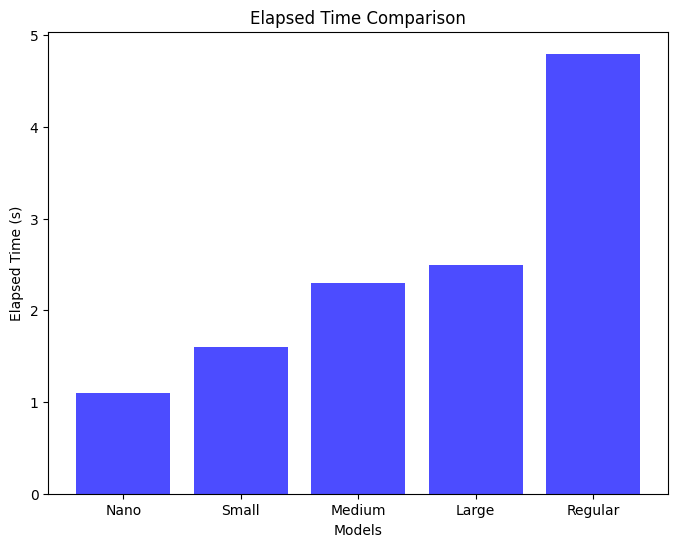

In [94]:
import matplotlib.pyplot as plt

# Data
models = ["Nano", "Small", "Medium", "Large", "Regular"]
elapsed_time = [1.1, 1.6, 2.3, 2.5, 4.8]

# Create a bar chart for elapsed time
plt.figure(figsize=(8, 6))
plt.bar(models, elapsed_time, color="b", alpha=0.7)
plt.xlabel("Models")
plt.ylabel("Elapsed Time (s)")
plt.title("Elapsed Time Comparison")
plt.show()

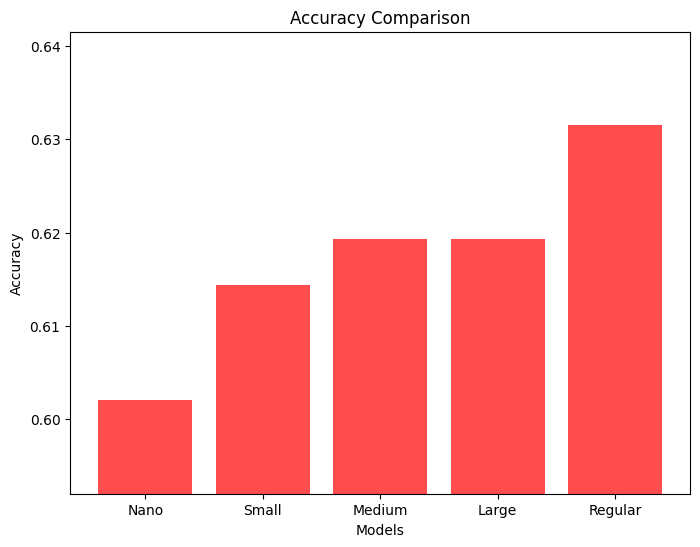

In [95]:
# Data
accuracy = [
    nano_accuracy,
    small_accuracy,
    medium_accuracy,
    large_accuracy,
    regular_accuracy,
]

# Create a bar chart for accuracy
plt.figure(figsize=(8, 6))
plt.bar(models, accuracy, color="r", alpha=0.7)
plt.xlabel("Models")
plt.ylabel("Accuracy")
plt.title("Accuracy Comparison")

# Adjust the y-axis limits to make differences more visible
plt.ylim(min(accuracy) - 0.01, max(accuracy) + 0.01)

plt.show()

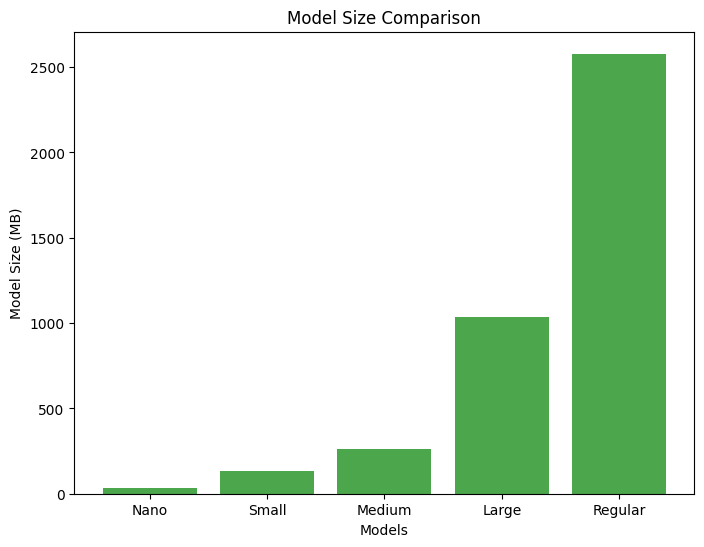

In [96]:
# Data
model_sizes = [
    nano_model_size_mb,
    small_model_size_mb,
    medium_model_size_mb,
    large_model_size_mb,
    regular_model_size_mb,
]

# Create a bar chart for model size
plt.figure(figsize=(8, 6))
plt.bar(models, model_sizes, color="g", alpha=0.7)
plt.xlabel("Models")
plt.ylabel("Model Size (MB)")
plt.title("Model Size Comparison")
plt.show()

# Выполнить то же самое но с использованием TfidfVectorizer


In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(
    stop_words="english", max_df=0.5, min_df=2
)

In [5]:
vectorizer.fit(X_train)

TfidfVectorizer(max_df=0.5, min_df=2, stop_words='english')

In [6]:
X_vect = vectorizer.transform(X_train)

print("Number of training samples:", (X_vect.shape[0]))
print("Number of training labels:", len(y_train))

Number of training samples: 1279715
Number of training labels: 1279715


In [7]:
X_vect_test = vectorizer.transform(X_test)

print("Number of training samples:", (X_vect_test.shape[0]))
print("Number of training labels:", len(y_test))

Number of training samples: 319929
Number of training labels: 319929


In [9]:
from sklearn.ensemble import RandomForestClassifier

rf_TF = RandomForestClassifier(n_estimators=30, n_jobs=-1, verbose=2)

In [29]:
rf_TF.fit(X_vect[:64000], y_train[:64000])

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 6 concurrent workers.


building tree 1 of 30building tree 2 of 30
building tree 3 of 30

building tree 4 of 30
building tree 5 of 30
building tree 6 of 30
building tree 7 of 30
building tree 8 of 30
building tree 9 of 30
building tree 10 of 30
building tree 11 of 30
building tree 12 of 30
building tree 13 of 30
building tree 14 of 30
building tree 15 of 30
building tree 16 of 30
building tree 17 of 30
building tree 18 of 30
building tree 19 of 30
building tree 20 of 30
building tree 21 of 30
building tree 22 of 30
building tree 23 of 30
building tree 24 of 30


In [14]:
rf_TF_small = RandomForestClassifier(n_estimators=30, n_jobs=-1, verbose=2)
rf_TF_small.fit(X_vect[:32000], y_train[:32000])

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 6 concurrent workers.


building tree 1 of 30building tree 2 of 30

building tree 3 of 30
building tree 4 of 30
building tree 5 of 30
building tree 6 of 30
building tree 7 of 30
building tree 8 of 30
building tree 9 of 30
building tree 10 of 30
building tree 11 of 30
building tree 12 of 30
building tree 13 of 30
building tree 14 of 30
building tree 15 of 30
building tree 16 of 30
building tree 17 of 30
building tree 18 of 30
building tree 19 of 30
building tree 20 of 30
building tree 21 of 30
building tree 22 of 30
building tree 23 of 30
building tree 24 of 30
building tree 25 of 30
building tree 26 of 30
building tree 27 of 30
building tree 28 of 30
building tree 29 of 30
building tree 30 of 30


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  2.2min finished


RandomForestClassifier(n_estimators=30, n_jobs=-1, verbose=2)

In [10]:
rf_TF_nano = RandomForestClassifier(n_estimators=30, n_jobs=-1, verbose=2)
rf_TF_nano.fit(X_vect[:16000], y_train[:16000])

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 6 concurrent workers.


building tree 1 of 30
building tree 2 of 30
building tree 3 of 30
building tree 4 of 30
building tree 5 of 30
building tree 6 of 30
building tree 7 of 30
building tree 8 of 30
building tree 9 of 30
building tree 10 of 30
building tree 11 of 30
building tree 12 of 30
building tree 13 of 30
building tree 14 of 30
building tree 15 of 30
building tree 16 of 30
building tree 17 of 30
building tree 18 of 30
building tree 19 of 30
building tree 20 of 30
building tree 21 of 30
building tree 22 of 30
building tree 23 of 30
building tree 24 of 30
building tree 25 of 30
building tree 26 of 30
building tree 27 of 30
building tree 28 of 30
building tree 29 of 30
building tree 30 of 30


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  1.1min finished


RandomForestClassifier(n_estimators=30, n_jobs=-1, verbose=2)

In [15]:
# Nano Model Accuracy
'''
medium_accuracy_TF = accuracy_score(
    rf_TF.predict(X_vect_test[:]), y_test[:]
)  # 128.000 train data
'''

small_accuracy_TF = accuracy_score(
    rf_TF_small.predict(X_vect_test[:]), y_test[:]
)  # 32.000 train data


nano_accuracy_TF = accuracy_score(
    rf_TF_nano.predict(X_vect_test[:]), y_test[:]
)  # 16.000 train data

[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    4.5s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    3.3s finished


In [16]:

print("Random forest accuracy - TEST DATA - Nano Model TF: %.4f" % nano_accuracy_TF)
print("Random forest accuracy - TEST DATA - Small Model TF: %.4f" % small_accuracy_TF)

Random forest accuracy - TEST DATA - Nano Model TF: 0.7114
Random forest accuracy - TEST DATA - Small Model TF: 0.7231


In [17]:
import pickle

filename = "finalized_model_nano_TF.sav"
pickle.dump(rf_TF_nano, open(filename, "wb"))
filename = "finalized_model_small_TF.sav"
pickle.dump(rf_TF_small, open(filename, "wb"))
"""
filename = "finalized_model_medium_TF.sav"
pickle.dump(rf_TF, open(filename, "wb"))
"""

'\nfilename = "finalized_model_medium_TF.sav"\npickle.dump(rf_TF, open(filename, "wb"))\n'

In [19]:
import os

nano_model_size_TF = os.path.getsize("./finalized_model_nano_TF.sav")
small_model_size_TF = os.path.getsize("./finalized_model_small_TF.sav")

#medium_model_size_TF = os.path.getsize("./finalized_model_medium_TF.sav")

nano_model_size_mb_TF = nano_model_size_TF / (1024 * 1024)
small_model_size_mb_TF = small_model_size_TF / (1024 * 1024)
#medium_model_size_mb_TF = medium_model_size_TF / (1024 * 1024)

# Print the sizes of the model files
print("Size of Nano Model File: {:.2f} MB".format(nano_model_size_mb_TF))
print("Size of Small Model File: {:.2f} MB".format(small_model_size_mb_TF))
#print("Size of Medium Model File: {:.2f} MB".format(medium_model_size_mb))

Size of Nano Model File: 29.58 MB
Size of Small Model File: 59.87 MB


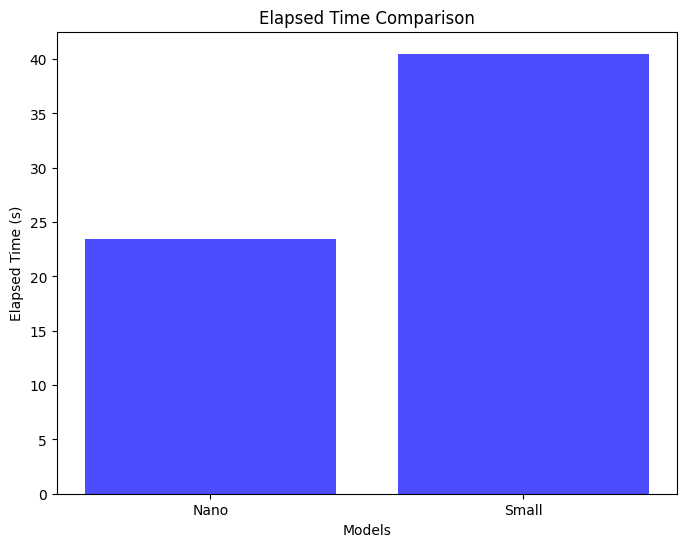

In [25]:
import matplotlib.pyplot as plt

# Data
models = ["Nano", "Small"]
elapsed_time = [23.4, 40.5]

# Create a bar chart for elapsed time
plt.figure(figsize=(8, 6))
plt.bar(models, elapsed_time, color="b", alpha=0.7)
plt.xlabel("Models")
plt.ylabel("Elapsed Time (s)")
plt.title("Elapsed Time Comparison")
plt.show()

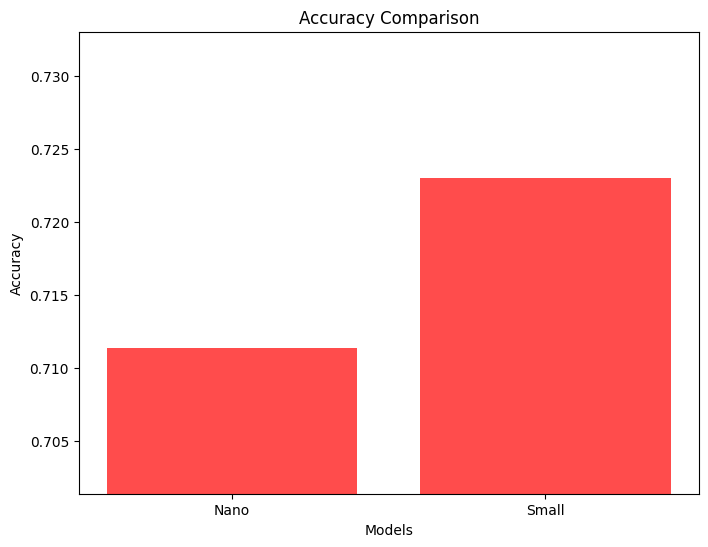

In [26]:
# Data
accuracy = [nano_accuracy_TF, small_accuracy_TF]

# Create a bar chart for accuracy
plt.figure(figsize=(8, 6))
plt.bar(models, accuracy, color="r", alpha=0.7)
plt.xlabel("Models")
plt.ylabel("Accuracy")
plt.title("Accuracy Comparison")

# Adjust the y-axis limits to make differences more visible
plt.ylim(min(accuracy) - 0.01, max(accuracy) + 0.01)

plt.show()

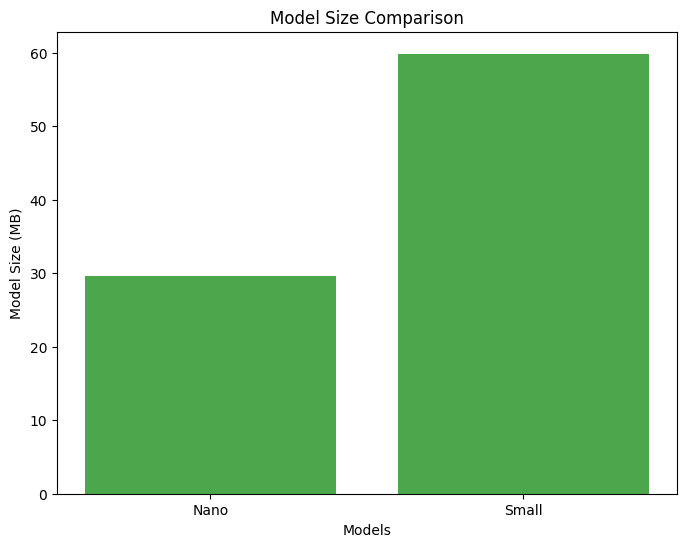

In [27]:
# Data
model_sizes = [nano_model_size_mb_TF, small_model_size_mb_TF]

# Create a bar chart for model size
plt.figure(figsize=(8, 6))
plt.bar(models, model_sizes, color="g", alpha=0.7)
plt.xlabel("Models")
plt.ylabel("Model Size (MB)")
plt.title("Model Size Comparison")
plt.show()

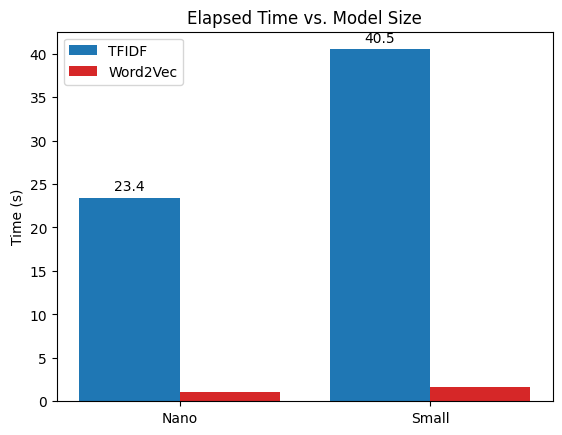

In [29]:
import matplotlib.pyplot as plt

# Data for the plot
models = ["Nano", "Small"]
elapsed_time_TF = [23.4, 40.5, 52.2]
elapsed_time_W2V = [1.1, 1.6, 2.3]

colors = {"TFIDF": "tab:blue", "W2V": "tab:red"}

width = 0.4  # the width of the bars
multiplier = 0

# Create the figure and axis object
fig, ax = plt.subplots()

# Plot the first set of bars
for model in models:
    rects = ax.bar(
        0 + multiplier,
        elapsed_time_TF[multiplier],
        width,
        color=colors.get("TFIDF"),
    )
    if multiplier == 0:
        rects.set_label("TFIDF")
    ax.bar_label(rects, padding=3)

    # Plot the second set of bars
    rects = ax.bar(
        width + multiplier,
        elapsed_time_W2V[multiplier],
        width,
        color=colors.get("W2V"),
    )
    if multiplier == 0:
        rects.set_label("Word2Vec")
    multiplier += 1


# Add a title and legend
ax.set_title("Elapsed Time vs. Model Size")
ax.set_ylabel("Time (s)")
ax.set_xticks(np.arange(len(models)) + width / 2, ["Nano", "Small"])
ax.legend()

# Show the plot
plt.show()

In [31]:
import matplotlib.pyplot as plt

# Data for the plot
models = ["Nano", "Small"]
accuracy_TF = [nano_accuracy_TF, small_accuracy_TF]
accuracy_W2V = [nano_accuracy, small_accuracy]

colors = {"TFIDF": "tab:blue", "W2V": "tab:red"}

width = 0.35  # the width of the bars
multiplier = 0

# Create the figure and axis object
fig, ax = plt.subplots()

# Plot the first set of bars
for model in models:
    rects = ax.bar(
        0 + multiplier,
        accuracy_TF[multiplier],
        width,
        color=colors.get("TFIDF"),
    )
    if multiplier == 0:
        rects.set_label("TFIDF")
    ax.bar_label(rects, padding=3)

    # Plot the second set of bars
    rects = ax.bar(
        width + multiplier,
        accuracy_W2V[multiplier],
        width,
        color=colors.get("W2V"),
    )
    if multiplier == 0:
        rects.set_label("Word2Vec")
    multiplier += 1


# Add a title and legend
ax.set_title("Accuracy vs. Model Size")
ax.set_ylabel("Accuracy")
ax.set_xticks(np.arange(len(models)) + width / 2, ["Nano", "Small"])
ax.legend()

# Show the plot
plt.show()

NameError: name 'nano_accuracy' is not defined

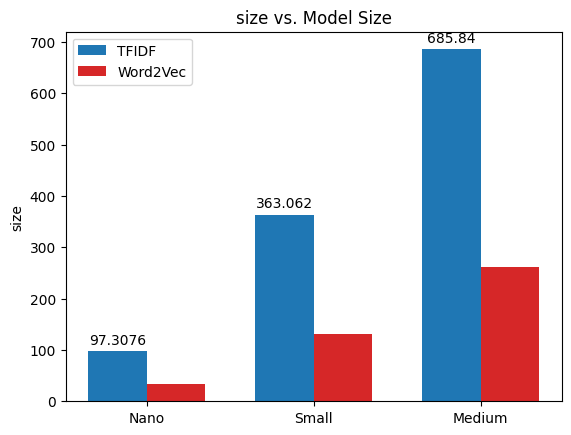

In [136]:
import matplotlib.pyplot as plt

# Data for the plot
models = ["Nano", "Small", "Medium"]
size_TF = [nano_model_size_mb_TF, small_model_size_mb_TF, medium_model_size_mb_TF]
size_W2V = [nano_model_size_mb, small_model_size_mb, medium_model_size_mb]

colors = {"TFIDF": "tab:blue", "W2V": "tab:red"}

width = 0.35  # the width of the bars
multiplier = 0

# Create the figure and axis object
fig, ax = plt.subplots()

# Plot the first set of bars
for model in models:
    rects = ax.bar(
        0 + multiplier,
        size_TF[multiplier],
        width,
        color=colors.get("TFIDF"),
    )
    if multiplier == 0:
        rects.set_label("TFIDF")
    ax.bar_label(rects, padding=3)

    # Plot the second set of bars
    rects = ax.bar(
        width + multiplier,
        size_W2V[multiplier],
        width,
        color=colors.get("W2V"),
    )
    if multiplier == 0:
        rects.set_label("Word2Vec")
    multiplier += 1


# Add a title and legend
ax.set_title("size vs. Model Size")
ax.set_ylabel("size")
ax.set_xticks(np.arange(len(models)) + width / 2, ["Nano", "Small", "Medium"])
ax.legend()

# Show the plot
plt.show()